In [1]:
%pylab inline
from jax.scipy.ndimage import map_coordinates
from constant import * 
import warnings
from jax import jit, partial
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


### Value iteration of renting a house

$$V_t(w_t,n_{t-1}, s_t, e_t) = max_{\{c_t, h_t, b_t, k_t\}}\{ u(c_t, h_t) + \beta E[P_t V_{t+1}(w_{t+1}, n_{t},s_{t+1}, e_{t+1}) + (1-P_t) u_B(w_{t+1}, n_{t})]\}$$
Subject to:    
$$y_t^{AT} + w_t = c_t + P_t^r h_t + b_t + k_t$$
$$ w_{t+1} = (1+r_t^f) b_t + (1+r_{t+1}^m) k_t $$   
$$n_t = g(n_{t-1}, x_t)$$

Shape of the state: $$(10 \times 10 \times 27 \times 2)$$
Shape of the actions: $$(20 \times 20)$$ 

Takes: 2m on 1 GPU, 5 m on 48 CPUs

Shape of the state: $$(20 \times 20 \times 27 \times 2)$$
Shape of the actions: $$(20 \times 20)$$

Takes: 22m on 48 CPUs

In [2]:
nX = Xs.shape[0]
Xs.shape

(5400, 4)

In [3]:
nA = As.shape[0]
As.shape

(400, 2)

In [4]:
X = jnp.repeat(Xs, nA, axis = 0)
A = jnp.tile(As, (nX,1))

In [5]:
#(17280000, 2)
A.shape

(2160000, 2)

In [6]:
X.shape

(2160000, 4)

In [7]:
detEarning = detEarning/3

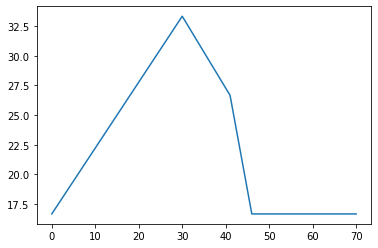

In [8]:
plt.plot(detEarning)

In [9]:
#Define the earning function, which applies for both employment, 27 states
@partial(jit, static_argnums=(0,))
def y(t, x):
    if t <= T_R:
        return detEarning[t] * (1+gGDP[jnp.array(x[:,2], dtype = jnp.int8)]) * x[:,3] + (1-x[:,3]) * welfare
    else:
        return detEarning[-1] * jnp.ones(X.shape[0])
    
#Earning after tax and fixed by transaction in and out from 401k account 
@partial(jit, static_argnums=(0,))
def yAT(t,x):
    yt = y(t, x)  
    if t <= T_R:
        # yi portion of the income will be put into the 401k if employed
        return (1-tau_L)*(yt * (1-yi))*x[:,3] + (1-x[:,3])*yt
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        return (1-tau_R)*yt + x[:,1]/Dt[t]
    
#Define the evolution of the amount in 401k account 
@partial(jit, static_argnums=(0,)) 
def gn(t, x, r):
    if t <= T_R:
        # if the person is employed, then yi portion of his income goes into 401k 
        n_cur = x[:,1] + y(t, x) * yi * x[:,3]
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        n_cur = x[:,1] - x[:,1]/Dt[t]
        # the 401 grow as the same rate as the stock 
    return (1+r)*n_cur

In [10]:
#Define the utility function
@jit
def u(c):
    return (jnp.power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth
@jit
def uB(tb):
    return B*u(tb)

#Reward function for renting
@jit
def u_rent(a):
    '''
    Input:
        action a: c, b, k, h = a
    Output:
        reward value: the length of return should be equal to the length of a
    '''
    c = a[:,0]
    h = a[:,3]
    C = jnp.power(c, alpha) * jnp.power(h, 1-alpha)
    return u(C)

@partial(jit, static_argnums=(2,))
def transition(x,a,t):
    '''
        imput: a is np array constains all possible actions 
        output: next time period x = [w, n, s, e]
    '''
    s = jnp.array(x[:,2], dtype = jnp.int8)
    e = jnp.array(x[:,3], dtype = jnp.int8)
    # actions taken
    b = a[:,1]
    k = a[:,2]
    w_next = ((1+r_b[s])*b + jnp.outer(k,(1+r_k)).T).T.flatten()
    s_next = jnp.tile(jnp.arange(nS),nA*nX)
    # growth rate of 401k is an average between stock and bond
#     n_next = gn(t, X.repeat(nS,axis = 0), (r_b[s].repeat(nS) + r_k[s_next])/2)
    n_next = gn(t, X.repeat(nS,axis = 0), 0.02)
    pe = Pe[s, e].repeat(nS)
    ps = Ps[s].flatten()
    prob_next = jnp.column_stack(((1-pe)*ps,pe*ps)).flatten()
    e_next = jnp.column_stack((e.repeat(nS),(1-e).repeat(nS))).flatten()
    return w_next.repeat(2), n_next.repeat(2), s_next.repeat(2), e_next, prob_next
    
# used to calculate dot product
@jit
def dotProduct(p_next, uBTB):
    return (p_next*uBTB).reshape((p_next.shape[0]//(nS*nE), (nS*nE))).sum(axis = 1)

# define approximation of fit
@jit
def fit(v, w_next, n_next, s_next, e_next):
    return map_coordinates(v.reshape(dim),jnp.vstack((w_next/scaleW,n_next/scaleN, s_next, e_next)), order = 1, mode = 'nearest')

@partial(jit, static_argnums=(0,))
def feasibleActions(t):
    # x = [w,n,s,e], a = [c,b,k,h]
    budget1 = yAT(t,X) + X[:,0]
#     h = budget1*A[:,0]/pr
#     budget2 = budget1*(1-A[:,0])
#     c = budget2*A[:,1]
#     budget3 = budget2*(1-A[:,1])
#     k = budget3*A[:,2]
#     b = budget3*(1-A[:,2])
    h = budget1*A[:,0]*0.2/pr
    c = budget1*A[:,0]*0.8
    budget2 = budget1*(1-A[:,0])
    k = budget2*A[:,1]
    b = budget2*(1-A[:,1])
    return jnp.column_stack((c,b,k,h))

In [11]:
%%time
correction = jnp.array(range(nX))*nA
for t in range(T_max-1,T_min, -1):
    print(t)
    actions = feasibleActions(t)
    w_next, n_next, s_next, e_next, prob_next = transition(X,actions,t)
    # if right before the terminal state the Q value is different 
    if t == T_max - 1:
        Q = u_rent(actions) + beta * dotProduct(prob_next, uB(w_next+n_next))
    else:
        Q = u_rent(actions) + beta * dotProduct(prob_next, Pa[t] * fit(V, w_next, n_next, s_next, e_next)
                                                + (1-Pa[t]) * uB(w_next+n_next))
    V = Q.reshape(nX,nA).max(axis = 1)
    cbkh = actions[Q.reshape(nX,nA).argmax(axis = 1) + correction]
        
    Vgrid[:,:,:,:,t] = V.reshape(dim)
    cgrid[:,:,:,:,t] = cbkh[:,0].reshape(dim)
    bgrid[:,:,:,:,t] = cbkh[:,1].reshape(dim)
    kgrid[:,:,:,:,t] = cbkh[:,2].reshape(dim)
    hgrid[:,:,:,:,t] = cbkh[:,3].reshape(dim)

59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
CPU times: user 14min 50s, sys: 5min 58s, total: 20min 49s
Wall time: 5min 2s


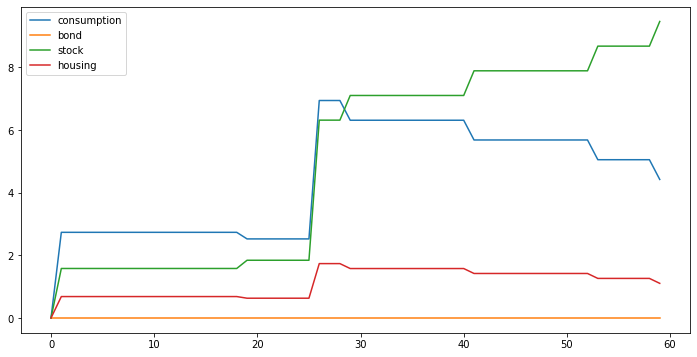

In [12]:
# plot consumption against time 
wealthLevel = 0
retirement = 0
econState = 1
employ = 0
plt.figure(figsize = [12,6])
plt.plot(cgrid[wealthLevel,retirement,econState,employ,:], label = "consumption")
plt.plot(bgrid[wealthLevel,retirement,econState,employ,:], label = "bond")
plt.plot(kgrid[wealthLevel,retirement,econState,employ,:], label = "stock")
plt.plot(hgrid[wealthLevel,retirement,econState,employ,:]*pr, label = "housing")
legend()

In [13]:
np.save('cgrid',cgrid)
np.save('bgrid',bgrid)
np.save('kgrid',kgrid)
np.save('hgrid',hgrid)

In [14]:
M = H*pt*0.8 
M

300.0

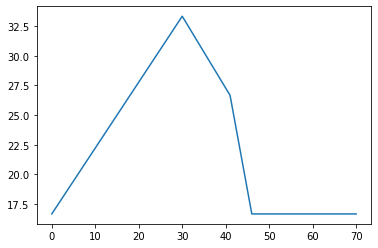

In [15]:
plt.plot(detEarning)

In [16]:
def mortgagePay(M, r, T):
    return M*r/(1-1/(1+r)**T)

In [17]:
c = mortgagePay(M, rh, 20)